In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from scipy.sparse.csgraph import laplacian

pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [3]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=1, extents=(1, 40), duration_of_trial=0.01, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 153.73it/s]


Using pyvistaqt 3d backend.

Using control points [0.0000000e+00 0.0000000e+00 1.1801564e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Use Generator

Using control points [0. 0. 1.]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


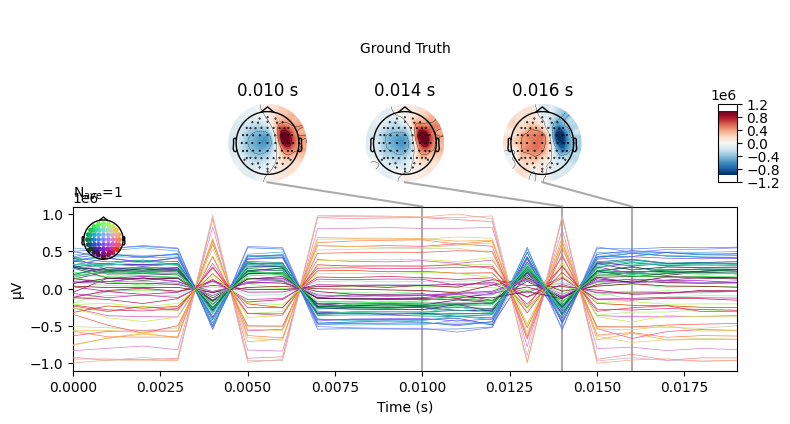

In [25]:
from invert.solvers.esinet import generator
gen = generator(fwd, use_cov=False, return_mask=False, batch_repetitions=30, n_sources=3, amplitude_range=(0.9,1))
x_test, y_test = gen.__next__()
evoked_ = mne.EvokedArray(x_test[0].T, info)

stc.data = y_test[0].T
stc.plot(**pp, brain_kwargs=dict(title="Ground Truth"))
%matplotlib qt
evoked_.plot_joint(title="Ground Truth")

In [8]:
# from invert.solvers.esinet import SolverFC
# solver_fc = SolverFC(verbose=1)
# solver_fc.make_inverse_operator(fwd, epochs=30)

stc_ = solver_fc.apply_inverse_operator(evoked_)
stc_.plot(**pp, brain_kwargs=dict(title="FC"))

NameError: name 'solver_fc' is not defined

In [21]:
# from invert.solvers.esinet import SolverLSTM

# solver_fc = SolverLSTM(verbose=1)
# solver_fc.make_inverse_operator(fwd, epochs=30)

stc_ = solver_fc.apply_inverse_operator(evoked_)
stc_.plot(**pp, brain_kwargs=dict(title="FC"))

Using control points [0.02396032 0.03326191 0.2653917 ]


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [28]:
from invert.solvers import SolverCovCNN
solver_cov = SolverCovCNN()
solver_cov.make_inverse_operator(fwd, n_filters=256, epochs=300)

solver_cov.epsilon=0.01
stc_ = solver_cov.apply_inverse_operator(evoked_)
stc_.plot(**pp, brain_kwargs=dict(title="CovCNN"))

Create Generator:..
Build Model:..
Train Model:..
Epoch 1/300
10/10 [==============================] - 5s 519ms/step - loss: -0.1407 - val_loss: -0.2127
Epoch 2/300
10/10 [==============================] - 5s 520ms/step - loss: -0.2031 - val_loss: -0.2286
Epoch 3/300
10/10 [==============================] - 5s 483ms/step - loss: -0.2470 - val_loss: -0.2404
Epoch 4/300
10/10 [==============================] - 5s 479ms/step - loss: -0.2969 - val_loss: -0.2485
Epoch 5/300
10/10 [==============================] - 5s 530ms/step - loss: -0.2732 - val_loss: -0.2583
Epoch 6/300
10/10 [==============================] - 5s 487ms/step - loss: -0.2977 - val_loss: -0.2726
Epoch 7/300
10/10 [==============================] - 5s 484ms/step - loss: -0.3190 - val_loss: -0.2851
Epoch 8/300
10/10 [==============================] - 5s 495ms/step - loss: -0.3199 - val_loss: -0.2926
Epoch 9/300
10/10 [==============================] - 5s 468ms/step - loss: -0.3340 - val_loss: -0.3021
Epoch 10/300
10/10 [===

In [ ]:
from invert.solvers import SolverCNN
solver_cnn = SolverCNN()
solver_cnn.make_inverse_operator(fwd, n_filters=256, epochs=300)

solver_cnn.epsilon=0.01
stc_ = solver_cnn.apply_inverse_operator(evoked_)
stc_.plot(**pp, brain_kwargs=dict(title="CNN"))

Active dipoles:  119
Using control points [0.0425531  0.05621638 0.13480481]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.         0.         0.25602449]
Using control points [0.04111385 0.05456048 0.1329649 ]
Using control points [0.04111385 0.05456048 0.1329649 ]
Using control points [0.     0.     0.3585]
